In [1]:
import glob
import os

import pandas as pd

In [24]:
# Ground Truth CSV
PATH = "../Data/"
gt_csv = PATH + "Dataset/CSVs/test_with_bg.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)
print("Número de Ground Truths: ", len(gt_df))

Número de Ground Truths:  542


In [28]:
gt_df["specie"].unique()

array(['Alaudidae', 'Anthus pratensis', 'Bird',
       'Calandrella brachydactyla', 'Carduelis carduelis', 'Cettia cetti',
       'Chloris chloris', 'Ciconia ciconia', 'Cisticola juncidis',
       'Curruca', 'Curruca melanocephala', 'Curruca undata',
       'Cyanopica cooki', 'Emberiza calandra', 'Falco tinnunculus',
       'Fringilla', 'Galerida theklae', 'Galerida Cristata',
       'Hippolais polyglotta', 'Lanius', 'Linaria Cannabina',
       'Luscinia megarhynchos', 'Melanocorypha calandra',
       'Merops apiaster', 'Milvus migrans', 'Motacilla flava',
       'Parus major', 'Passer', 'Pica pica', 'Saxicola rubicola',
       'Serinus serinus', 'Streptopelia decaocto', 'Sturnus',
       'Sturnus unicolor', 'Sylvia', 'Turdus merula', 'No audio'],
      dtype=object)

In [30]:
# delete rows whose specie is Bird, Alaudidae, Fringilla, Lanius
gt_df = gt_df[gt_df["specie"] != "Bird"]
gt_df = gt_df[gt_df["specie"] != "Alaudidae"]
gt_df = gt_df[gt_df["specie"] != "Fringilla"]
gt_df = gt_df[gt_df["specie"] != "Lanius"]

# Make Curruca, Curruca melanocephala and Curruca undata Sylvia
gt_df["specie"] = gt_df["specie"].replace("Curruca melanocephala", "Sylvia")
gt_df["specie"] = gt_df["specie"].replace("Curruca undata", "Sylvia")
gt_df["specie"] = gt_df["specie"].replace("Curruca", "Sylvia")

# Make Sturnus unicolor, Sturnus
gt_df["specie"] = gt_df["specie"].replace("Sturnus unicolor", "Sturnus")

print("Número de Ground Truths: ", len(gt_df))

Número de Ground Truths:  429


### Functions to group predictions and ground truth annotations (if same specie and overlapping times)

In [3]:
def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)
    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)
    
    return combined_annotations

In [31]:
gt_df = group_consecutive_annotations_gt(gt_df)
gt_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame
print("Número de Ground Truths agrupados: ", len(gt_df))

Número de Ground Truths agrupados:  335


### Auxiliar Functions

In [5]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

In [6]:
def is_detection_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if iou >= iou_threshold:
                return True
    return False

def is_detection_classification_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if (prediction['Scientific name'].lower() == gt_row['specie'].lower() and
                iou >= iou_threshold):
                return True
    return False

In [7]:
def display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives):
    print("================== Metrics ==================\n")
    print(f"Total Predictions: {total_predictions}")
    print(f"Total Predictions with Score >= {prediction_conf_score}: {total_predictions_score}")
    print(f"Total GT: {total_gt}")
    print(f"Correct Predictions Detector: {true_positives_detector}")
    print(f"Correct Predictions Detector + Classifier: {correct_predictions}")

    # Additional calculations for precision, recall, and F1-score
    print("\n================== Detector Metrics ==================\n")

    # Calculate and display the metrics
    accuracy_detector = (true_positives_detector + true_negatives) / (true_positives_detector + true_negatives + false_positives + false_negatives_detector) if true_positives_detector + true_negatives + false_positives + false_negatives_detector != 0 else 0
    precision_detector = true_positives_detector / (true_positives_detector + false_positives) if true_positives_detector + false_positives != 0 else 0
    recall_detector = true_positives_detector / (true_positives_detector + false_negatives_detector) if true_positives_detector + false_negatives_detector != 0 else 0
    f1_score_detector = 2 * precision_detector * recall_detector / (precision_detector + recall_detector) if precision_detector + recall_detector != 0 else 0
    print(f"Accuracy: {accuracy_detector}")
    print(f"Precision: {precision_detector}")
    print(f"Recall: {recall_detector}")
    print(f"F1-Score: {f1_score_detector}")

    print("\n================== Detector + Classifier Metrics ==================\n")

    # Calculate and display the metrics
    accuracy_classifier = (true_positives_classifier + true_negatives) / (true_positives_classifier + true_negatives + false_positives + false_negatives_detector) if true_positives_classifier + true_negatives + false_positives + false_negatives_classifier != 0 else 0
    precision_classifier = true_positives_classifier / (true_positives_classifier + false_positives) if true_positives_classifier + false_positives != 0 else 0
    recall_classifier = true_positives_classifier / (true_positives_classifier + false_negatives_detector) if true_positives_classifier + false_negatives_detector != 0 else 0
    f1_score_classifier = 2 * precision_classifier * recall_classifier / (precision_classifier + recall_classifier) if precision_classifier + recall_classifier != 0 else 0
    print(f"Accuracy: {accuracy_classifier}")
    print(f"Precision: {precision_classifier}")
    print(f"Recall: {recall_classifier}")
    print(f"F1-Score: {f1_score_classifier}")

    print("\n================== Other ==================\n")
    print(f"False Positives: {false_positives}")

def analyze_predictions_BirdNET(analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    # Variables for metrics
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0

    total_gt = len(gt_df)

    # Metrics
    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None

    # Process the predictions
    for _, gt_annotation in gt_df.iterrows():
        # Load the predictions
        prediction_path = f"../BirdNET/Predictions/{analysis_name}/{gt_annotation['path'].replace('.WAV', '.BirdNET.results.csv')}"

        current_file = gt_annotation['path']

        try:
            predictions_df = pd.read_csv(prediction_path)
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)  # Group predictions

            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score

            # If the annotation if not a background
            if gt_annotation['specie'] != 'No audio':
                # Check if the GT is detected by the detector
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                else:
                    false_negatives_classifier += 1
            else: # Annotation is a background
                # Take only grouped_predictions with confidence >= prediction_conf_score
                if current_predictions_score == 0:
                    true_negatives += 1
                else: # Background is unique file, with no annotations, so all predictions on that file are false positives
                    false_positives += current_predictions_score

            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    # Calculate and display the metrics
    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

In [8]:
def analyze_predictions_YOLO_BirdNET(gt_df, analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    # Variables for metrics
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0
    total_gt = len(gt_df)
    # Metrics
    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None

    # Process the predictions
    for _, gt_annotation in gt_df.iterrows():
        gt_basename = gt_annotation['path'].split('/')[-1]
        gt_basename_no_ext = os.path.splitext(gt_basename)[0]
        # Assuming the structure of the file name is consistent with the example given
        prediction_files = os.listdir(f"../BirdNET/Predictions/{analysis_name}")
        prediction_files_filtered = [file for file in prediction_files if file.startswith(gt_basename_no_ext)]

        current_file = gt_annotation['path']
        
        # predictions_df initialization
        predictions_df = pd.DataFrame(columns=['Start (s)', 'End (s)', 'Scientific name', 'Common name', 'Confidence'])

        for prediction_file in prediction_files_filtered:
            start_time, end_time = prediction_file.split('_')[-2:]
            end_time = end_time.split('.BirdNET')[0]
            start_time = float(start_time)
            end_time = float(end_time)
            prediction_path = f"../BirdNET/Predictions/{analysis_name}/{prediction_file}"

            # Create prediction DataFrame and append all of current prediction file
            current_prediction_df = pd.read_csv(prediction_path)

            # Set start and end times
            current_prediction_df['Start (s)'] = float(start_time)
            current_prediction_df['End (s)'] = float(end_time)

            # If current_prediction_df is not empty, concatenate it to predictions_df
            if not current_prediction_df.empty:
                if predictions_df.empty:
                    predictions_df = current_prediction_df
                else:
                    predictions_df = pd.concat([predictions_df, current_prediction_df], ignore_index=True)

        grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)  # Group predictions
        
        try:
            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score
            # If the annotation if not a background
            if gt_annotation['specie'] != 'No audio':
                # Check if the GT is detected by the detector
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                else:
                    false_negatives_classifier += 1
            else: # Annotation is a background
                # Take only grouped_predictions with confidence >= prediction_conf_score
                if current_predictions_score == 0:
                    true_negatives += 1
                else: # Background is unique file, with no annotations, so all predictions on that file are false positives
                    false_positives += current_predictions_score
            
            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    # Calculate and display the metrics
    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives):
    print("================== Metrics ==================\n")
    print(f"Total Predictions: {total_predictions}")
    print(f"Total Predictions with Score >= {prediction_conf_score}: {total_predictions_score}")
    print(f"Total GT: {total_gt}")
    print(f"Correct Predictions Detector: {true_positives_detector}")
    print(f"Correct Predictions Detector + Classifier: {correct_predictions}")

    print("\n================== Detector Metrics ==================\n")
    accuracy_detector = (true_positives_detector + true_negatives) / (true_positives_detector + true_negatives + false_positives + false_negatives_detector) if true_positives_detector + true_negatives + false_positives + false_negatives_detector != 0 else 0
    precision_detector = true_positives_detector / (true_positives_detector + false_positives) if true_positives_detector + false_positives != 0 else 0
    recall_detector = true_positives_detector / (true_positives_detector + false_negatives_detector) if true_positives_detector + false_negatives_detector != 0 else 0
    f1_score_detector = 2 * precision_detector * recall_detector / (precision_detector + recall_detector) if precision_detector + recall_detector != 0 else 0
    print(f"Accuracy: {accuracy_detector}")
    print(f"Precision: {precision_detector}")
    print(f"Recall: {recall_detector}")
    print(f"F1-Score: {f1_score_detector}")

    print("\n================== Detector + Classifier Metrics ==================\n")
    accuracy_classifier = (true_positives_classifier + true_negatives) / (true_positives_classifier + true_negatives + false_positives + false_negatives_classifier) if true_positives_classifier + true_negatives + false_positives + false_negatives_classifier != 0 else 0
    precision_classifier = true_positives_classifier / (true_positives_classifier + false_positives) if true_positives_classifier + false_positives != 0 else 0
    recall_classifier = true_positives_classifier / (true_positives_classifier + false_negatives_classifier) if true_positives_classifier + false_negatives_classifier != 0 else 0
    f1_score_classifier = 2 * precision_classifier * recall_classifier / (precision_classifier + recall_classifier) if precision_classifier + recall_classifier != 0 else 0
    print(f"Accuracy: {accuracy_classifier}")
    print(f"Precision: {precision_classifier}")
    print(f"Recall: {recall_classifier}")
    print(f"F1-Score: {f1_score_classifier}")

    print("\n================== Other ==================\n")
    print(f"False Positives: {false_positives}")

def analyze_predictions_BirdNET(analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0
    total_gt = len(gt_df)

    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None
    y_true = []
    y_pred = []
    species_list = sorted(gt_df['specie'].unique())

    for _, gt_annotation in gt_df.iterrows():
        prediction_path = f"../BirdNET/Predictions/{analysis_name}/{gt_annotation['path'].replace('.WAV', '.BirdNET.results.csv')}"
        current_file = gt_annotation['path']

        try:
            predictions_df = pd.read_csv(prediction_path)
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)

            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score

            grouped_predictions = [p for p in grouped_predictions if p["Confidence"] >= prediction_conf_score]

            if gt_annotation['specie'] != 'No audio':
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    score_threshold = False
                    for prediction in grouped_predictions:
                        if prediction['Confidence'] >= prediction_conf_score:
                            score_threshold = True

                    if score_threshold:
                        false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                    y_true.append(gt_annotation['specie'])
                    y_pred.append(get_predicted_species(grouped_predictions, prediction_conf_score))
                else:
                    false_negatives_classifier += 1
                    score_threshold = False
                    for prediction in grouped_predictions:
                        if prediction['Confidence'] >= prediction_conf_score:
                            score_threshold = True
                    
                    if score_threshold:
                        y_true.append(gt_annotation['specie'])
                        y_pred.append('Unknown')
            else:
                if current_file != last_file:
                    if current_predictions_score == 0:
                        true_negatives += 1
                    else:
                        false_positives += current_predictions_score

            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

    # Matriz de confusión general (Detector)
    cm_general = np.array([[true_positives_detector, false_negatives_detector],
                        [false_positives, true_negatives]])
    disp_general = ConfusionMatrixDisplay(confusion_matrix=cm_general, display_labels=['Positive', 'Negative'])
    plt.figure(figsize=(8, 6))
    disp_general.plot(cmap='Blues')
    plt.title('Confusion Matrix (General)')
    plt.show()

    # Matriz de confusión general normalizada
    cm_general = np.array([[true_positives_detector, false_negatives_detector],
                       [false_positives, true_negatives]])

    # Normalizar la matriz de confusión
    cm_general_normalized = cm_general.astype('float') / cm_general.sum(axis=1)[:, np.newaxis]

    # Asegurar que el valor mínimo sea 0
    cm_general_normalized = np.nan_to_num(cm_general_normalized)

    # Crear el display de la matriz de confusión normalizada
    disp_general_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_general_normalized, display_labels=['Positive', 'Negative'])

    # Configurar la figura
    plt.figure(figsize=(8, 6))

    # Dibujar la matriz de confusión con cmap 'Blues'
    disp_general_normalized.plot(cmap='Blues')
    plt.show()

    # Matriz de confusión por especie
    cm_species = confusion_matrix(y_true, y_pred, labels=species_list)
    plt.figure(figsize=(20, 20))
    disp_species = ConfusionMatrixDisplay(confusion_matrix=cm_species, display_labels=species_list)
    disp_species.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix by Species (Non-normalized)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Matriz de confusión por especie normalizada
    cm_species_normalized = confusion_matrix(y_true, y_pred, labels=species_list, normalize='true')
    plt.figure(figsize=(20, 20))
    disp_species_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_species_normalized, display_labels=species_list)
    disp_species_normalized.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix by Species (Normalized)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

def get_predicted_species(grouped_predictions, prediction_conf_score):
    high_conf_predictions = [p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score]
    if high_conf_predictions:
        return max(high_conf_predictions, key=lambda x: x['Confidence'])['Scientific name']
    else:
        return 'Unknown'

# Ejemplo de uso
# analyze_predictions_BirdNET('nombre_del_experimento')


## Métricas de BirdNET Base con la lista de especies de Doñana de BIRDeep

================== Metrics ==================

Total Predictions: 194
Total Predictions with Score >= 0.6: 27
Total GT: 403
Correct Predictions Detector: 39
Correct Predictions Detector + Classifier: 10

================== Detector Metrics ==================

Accuracy: 0.27522935779816515
Precision: 1.0
Recall: 0.19796954314720813
F1-Score: 0.3305084745762712

================== Detector + Classifier Metrics ==================

Accuracy: 0.07692307692307693
Precision: 1.0
Recall: 0.02617801047120419
F1-Score: 0.05102040816326531

================== Other ==================

False Positives: 0


<Figure size 800x600 with 0 Axes>

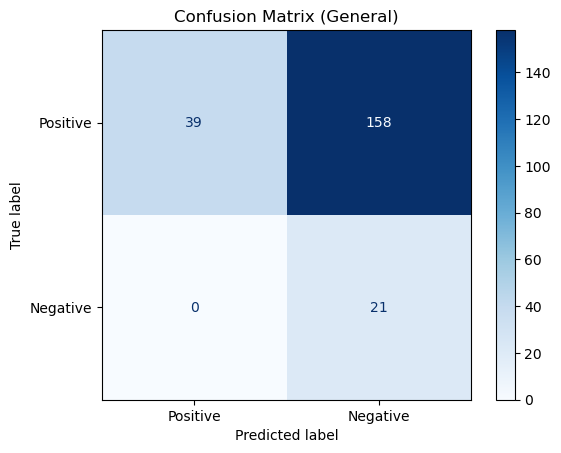

<Figure size 800x600 with 0 Axes>

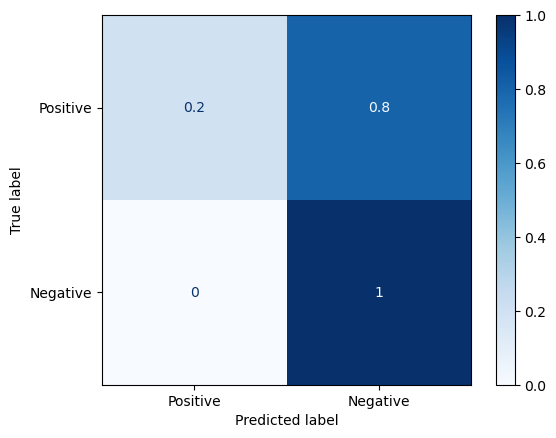

<Figure size 2000x2000 with 0 Axes>

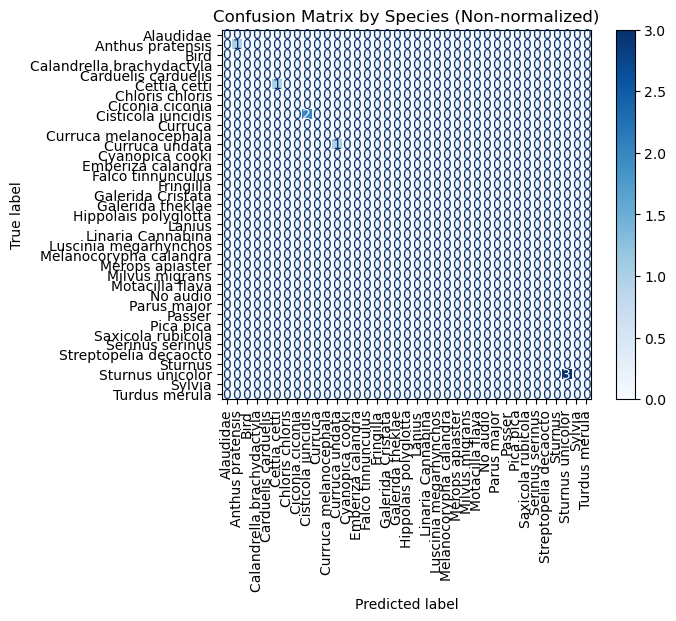

<Figure size 2000x2000 with 0 Axes>

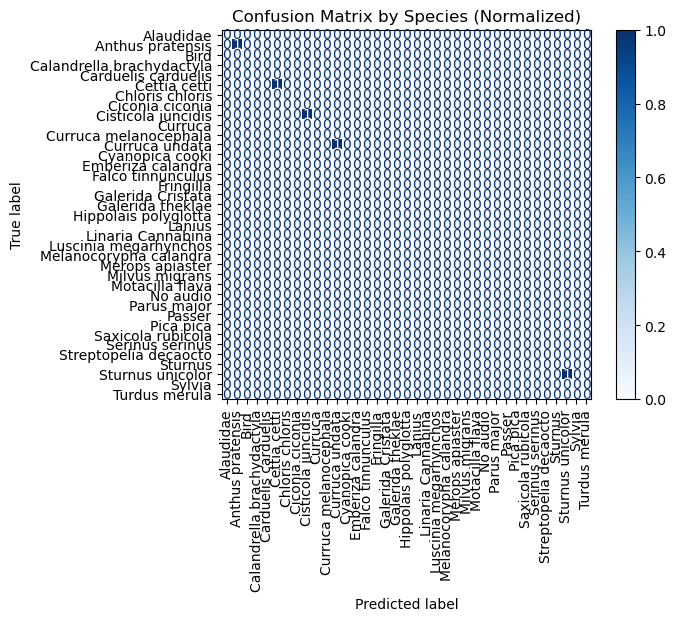

In [10]:
analyze_predictions_BirdNET("0_BirdNet_Base_AllTest_DonanaSpecies", 0.6, 0.2)

## Métricas de BirdNET Base con la lista de especies del customClassifier

================== Metrics ==================

Total Predictions: 160
Total Predictions with Score >= 0.6: 39
Total GT: 403
Correct Predictions Detector: 48
Correct Predictions Detector + Classifier: 19

================== Detector Metrics ==================

Accuracy: 0.27419354838709675
Precision: 0.9795918367346939
Recall: 0.21145374449339208
F1-Score: 0.34782608695652173

================== Detector + Classifier Metrics ==================

Accuracy: 0.0967741935483871
Precision: 0.95
Recall: 0.049738219895287955
F1-Score: 0.0945273631840796

================== Other ==================

False Positives: 1


<Figure size 800x600 with 0 Axes>

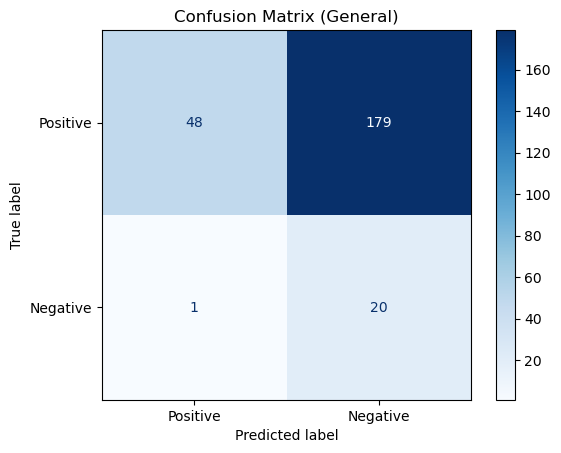

<Figure size 800x600 with 0 Axes>

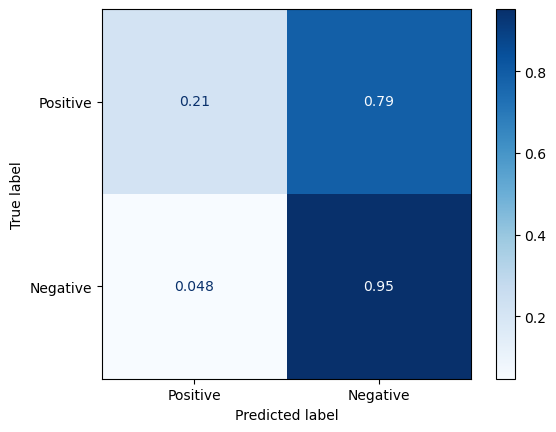

<Figure size 2000x2000 with 0 Axes>

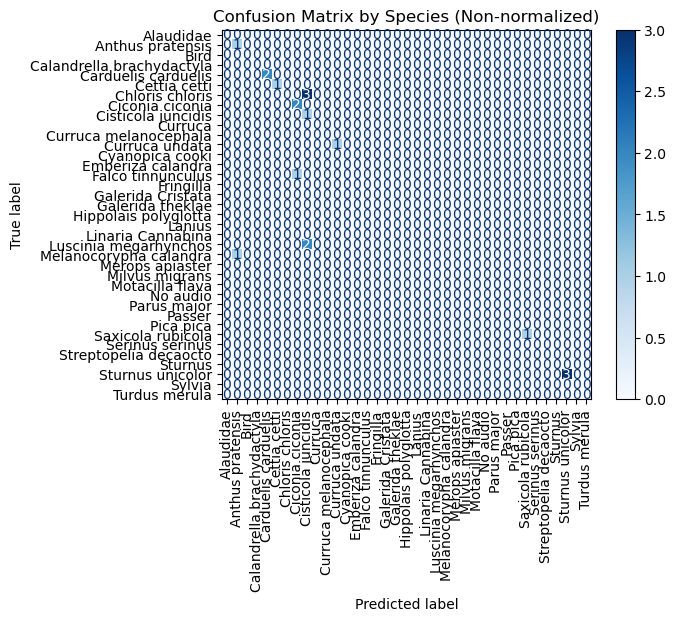

<Figure size 2000x2000 with 0 Axes>

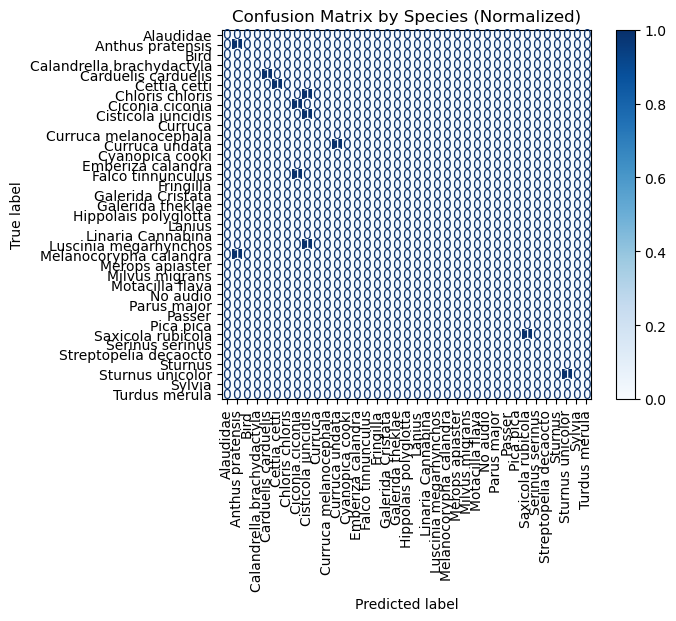

In [11]:
analyze_predictions_BirdNET("1_BirdNet_Base_AllTest_ClassifierSpecies", 0.6, 0.2)

================== Metrics ==================

Total Predictions: 160
Total Predictions with Score >= 0.1: 160
Total GT: 403
Correct Predictions Detector: 114
Correct Predictions Detector + Classifier: 51

================== Detector Metrics ==================

Accuracy: 0.36164383561643837
Precision: 0.95
Recall: 0.3343108504398827
F1-Score: 0.4945770065075922

================== Detector + Classifier Metrics ==================

Accuracy: 0.16995073891625614
Precision: 0.8947368421052632
Recall: 0.13350785340314136
F1-Score: 0.23234624145785876

================== Other ==================

False Positives: 6


<Figure size 800x600 with 0 Axes>

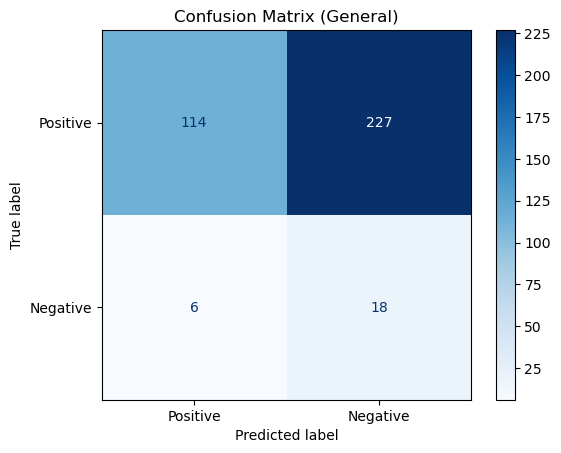

<Figure size 800x600 with 0 Axes>

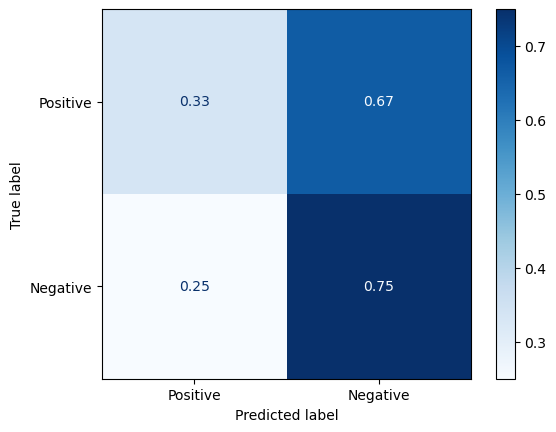

<Figure size 2000x2000 with 0 Axes>

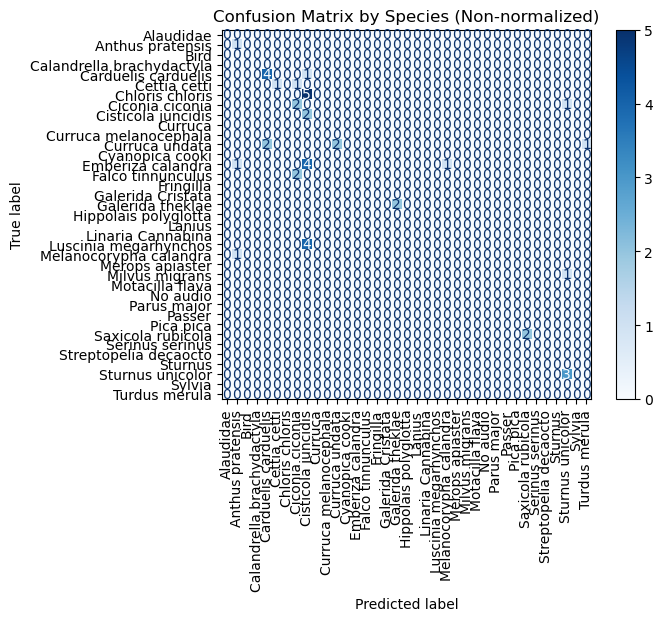

<Figure size 2000x2000 with 0 Axes>

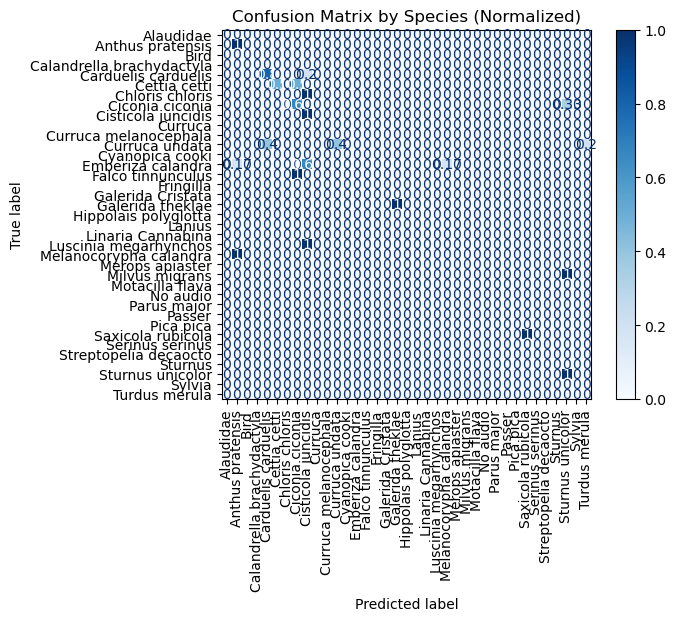

In [12]:
analyze_predictions_BirdNET("1_BirdNet_Base_AllTest_ClassifierSpecies", 0.1, 0.2)

## Métricas de BirdNET Fine Tuned

Baja los scores de las clases con las que ha sido entrenado, teniendo que bajar la threshold mucho. Haciendo que haya muchos más Falsos Positivos (en los casos anteriores con 0.6 -> 0, 6... FP, ahora hay que bajar hasta 0.1 el accuracy es mejor pero tenemos muchos Falsos Positivos)

## BirdNET Fine Tuned - DA

- analyze_predictions_BirdNET("4_BaseClassifier", 0.2, 0.2)
- analyze_predictions_BirdNET("5_DA_AllSpecies_Classifier", 0.2, 0.2)
- analyze_predictions_BirdNET("6_CustomClassifier_DA_Smote", 0.2, 0.2)
- analyze_predictions_BirdNET("7_CustomClassifier_DA_Smote_MoreUpSampling", 0.2, 0.2)
- analyze_predictions_BirdNET("8_CustomClassifier_Append", 0.6, 0.2)

================== Metrics ==================

Total Predictions: 1468
Total Predictions with Score >= 0.1: 1468
Total GT: 403
Correct Predictions Detector: 256
Correct Predictions Detector + Classifier: 96

================== Detector Metrics ==================

Accuracy: 0.4507042253521127
Precision: 0.579185520361991
Recall: 0.6701570680628273
F1-Score: 0.6213592233009709

================== Detector + Classifier Metrics ==================

Accuracy: 0.16901408450704225
Precision: 0.3404255319148936
Recall: 0.2513089005235602
F1-Score: 0.2891566265060241

================== Other ==================

False Positives: 186


<Figure size 800x600 with 0 Axes>

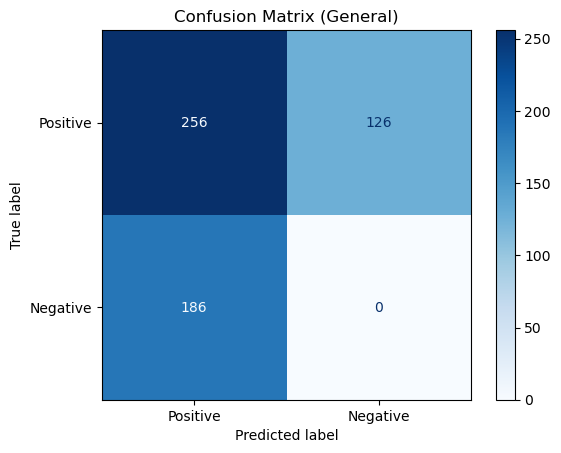

<Figure size 800x600 with 0 Axes>

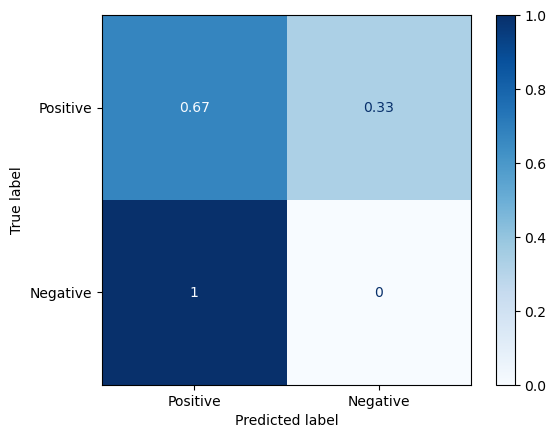

<Figure size 2000x2000 with 0 Axes>

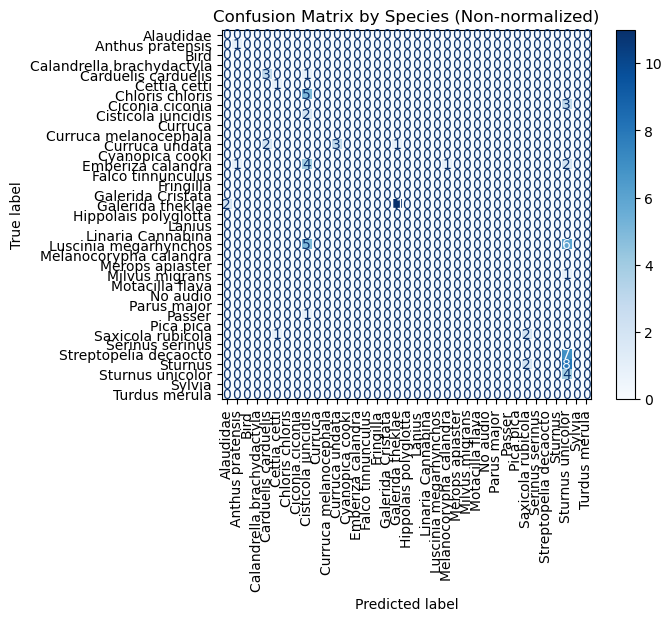

<Figure size 2000x2000 with 0 Axes>

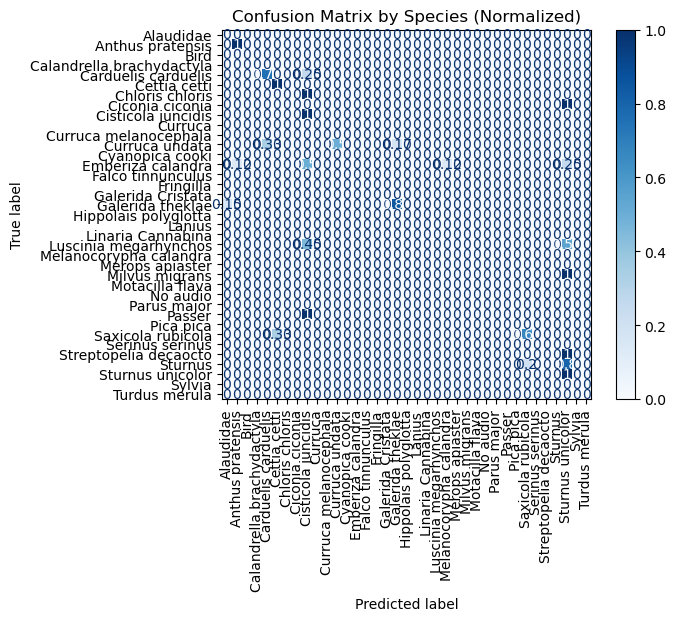

In [20]:
analyze_predictions_BirdNET("8_CustomClassifier_Append", 0.1, 0.2)

================== Metrics ==================

Total Predictions: 743
Total Predictions with Score >= 0.1: 743
Total GT: 335
Correct Predictions Detector: 205
Correct Predictions Detector + Classifier: 114

================== Detector Metrics ==================

Accuracy: 0.5549738219895288
Precision: 0.7649253731343284
Recall: 0.657051282051282
F1-Score: 0.706896551724138

================== Detector + Classifier Metrics ==================

Accuracy: 0.3151041666666667
Precision: 0.6440677966101694
Recall: 0.3630573248407643
F1-Score: 0.4643584521384928

================== Other ==================

False Positives: 63


<Figure size 800x600 with 0 Axes>

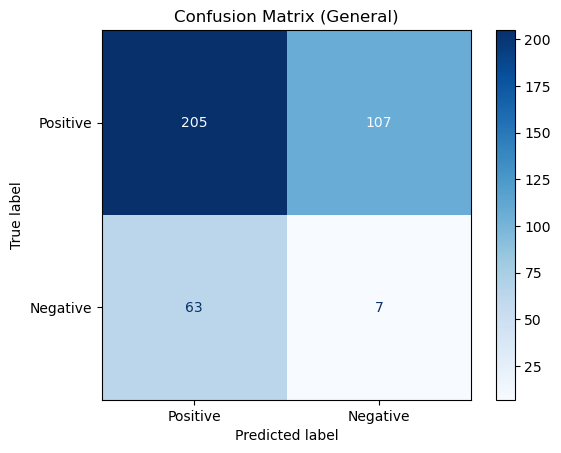

<Figure size 800x600 with 0 Axes>

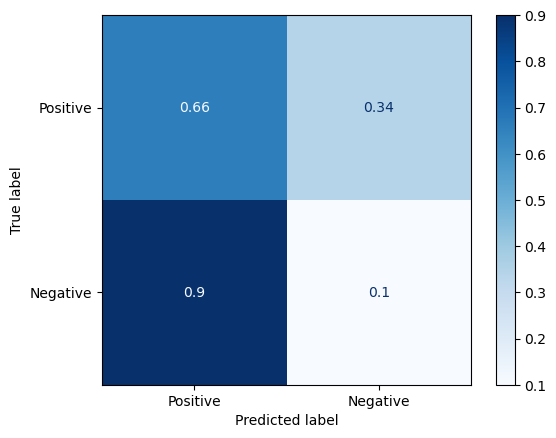

<Figure size 2000x2000 with 0 Axes>

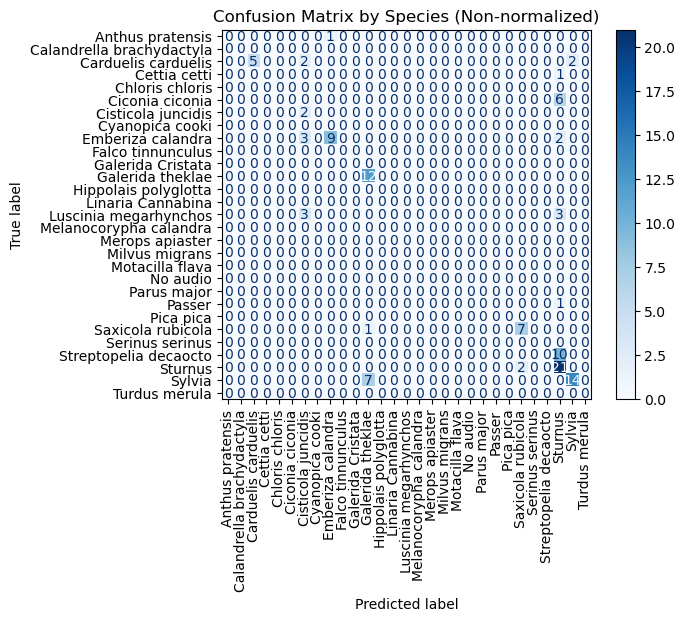

<Figure size 2000x2000 with 0 Axes>

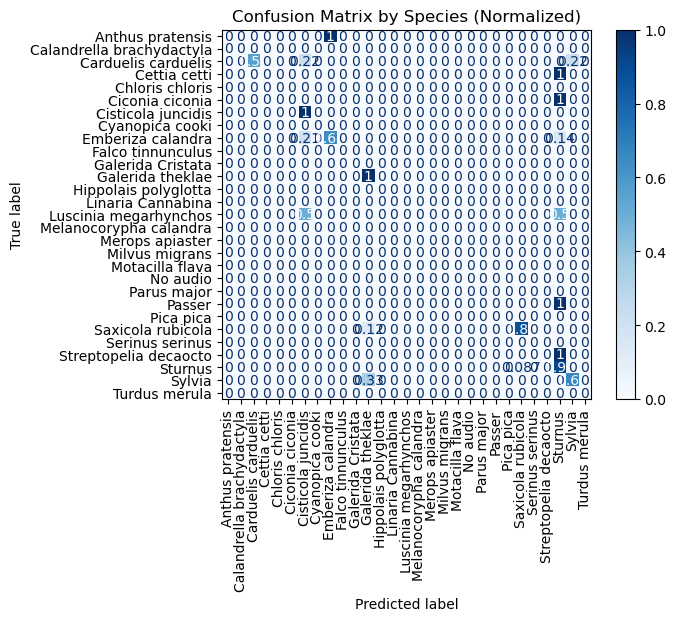

In [32]:
analyze_predictions_BirdNET("2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", 0.1, 0.2)

================== Metrics ==================

Total Predictions: 782
Total Predictions with Score >= 0.6: 109
Total GT: 403
Correct Predictions Detector: 98
Correct Predictions Detector + Classifier: 32

================== Detector Metrics ==================

Accuracy: 0.3483483483483483
Precision: 0.9423076923076923
Recall: 0.31715210355987056
F1-Score: 0.47457627118644063

================== Detector + Classifier Metrics ==================

Accuracy: 0.12315270935960591
Precision: 0.8421052631578947
Recall: 0.08376963350785341
F1-Score: 0.1523809523809524

================== Other ==================

False Positives: 6


<Figure size 800x600 with 0 Axes>

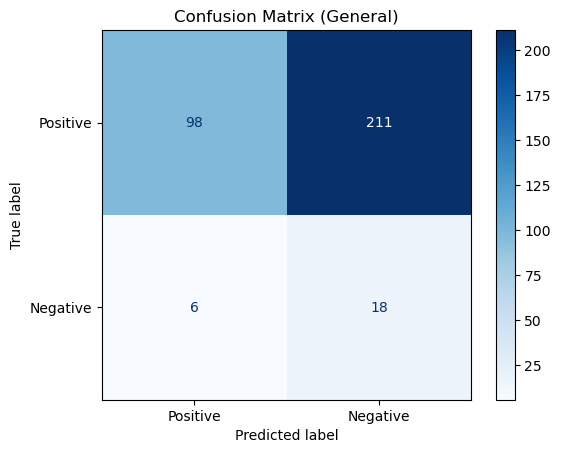

<Figure size 800x600 with 0 Axes>

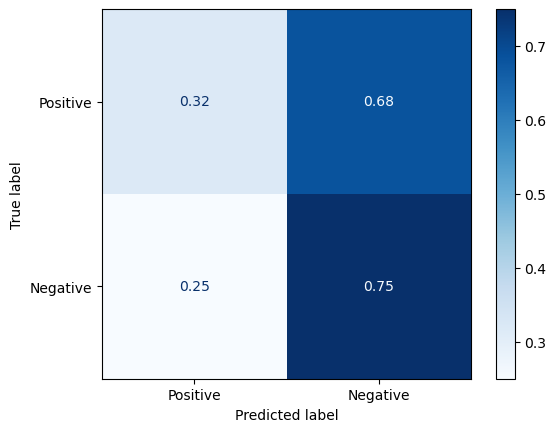

<Figure size 2000x2000 with 0 Axes>

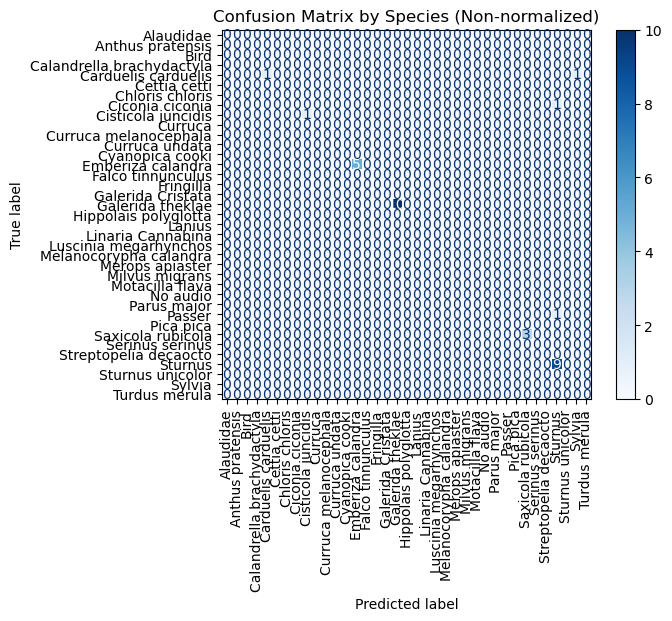

<Figure size 2000x2000 with 0 Axes>

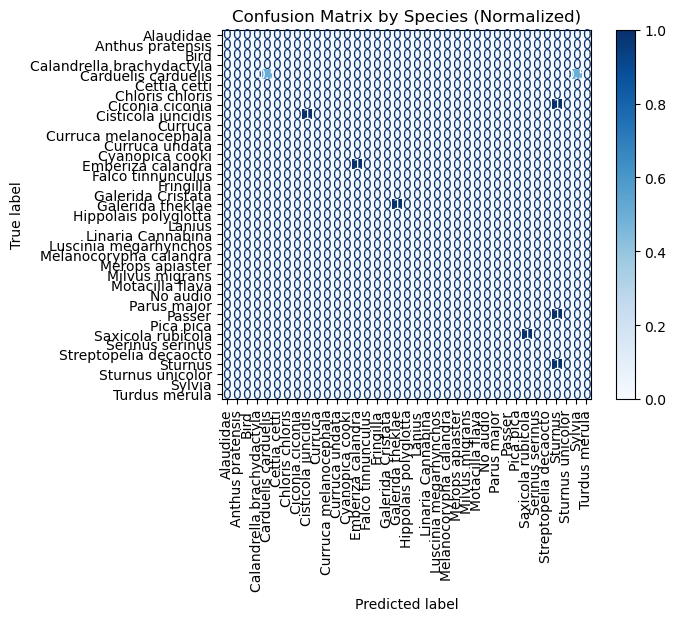

In [21]:
analyze_predictions_BirdNET("2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", 0.6, 0.2)

## Métricas de BirdNET customClassifier con los recortes de YOLOv8 para test

================== Metrics ==================

Total Predictions: 743
Total Predictions with Score >= 0.1: 743
Total GT: 335
Correct Predictions Detector: 205
Correct Predictions Detector + Classifier: 114

================== Detector Metrics ==================

Accuracy: 0.5549738219895288
Precision: 0.7649253731343284
Recall: 0.657051282051282
F1-Score: 0.706896551724138

================== Detector + Classifier Metrics ==================

Accuracy: 0.3151041666666667
Precision: 0.6440677966101694
Recall: 0.3630573248407643
F1-Score: 0.4643584521384928

================== Other ==================

False Positives: 63


<Figure size 800x600 with 0 Axes>

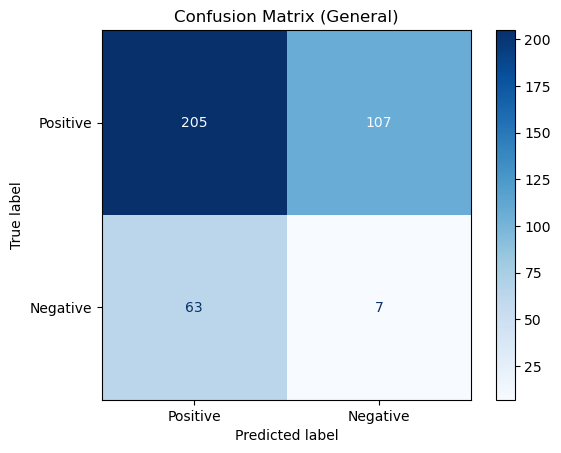

<Figure size 800x600 with 0 Axes>

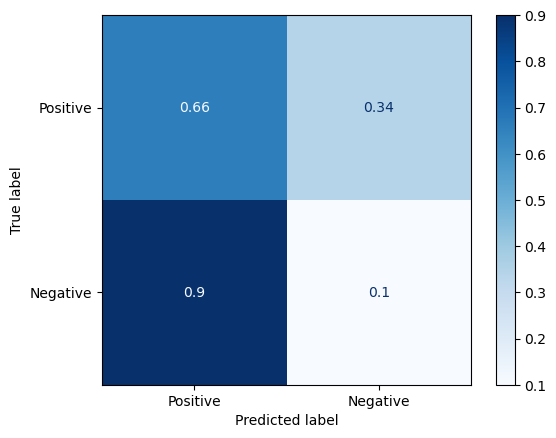

<Figure size 2000x2000 with 0 Axes>

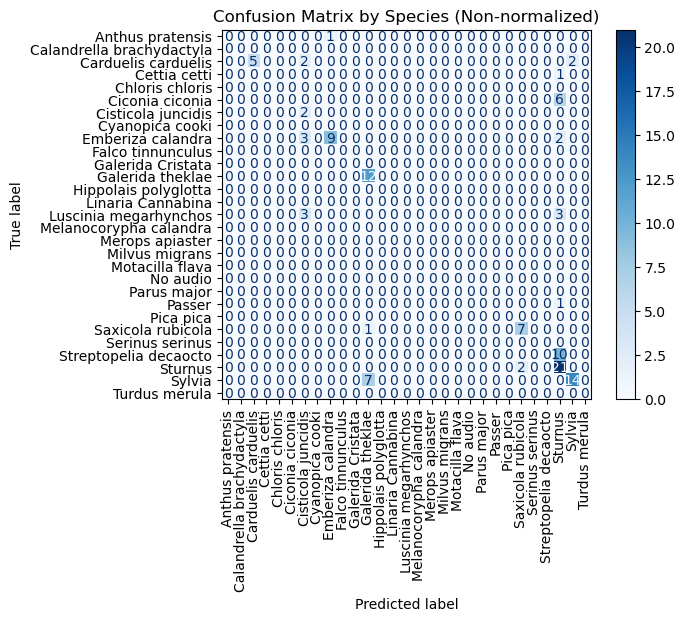

<Figure size 2000x2000 with 0 Axes>

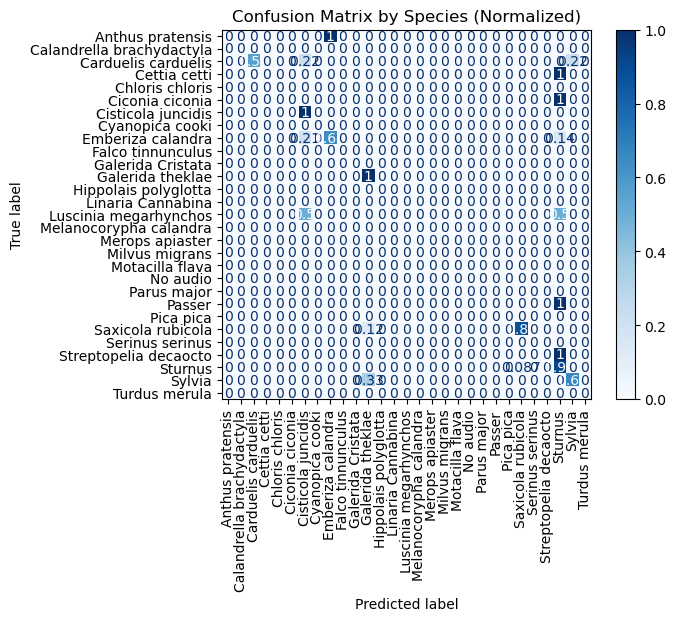

In [33]:
analyze_predictions_BirdNET("BirdSongDetector_and_2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", 0.1, 0.2)

In [191]:
# Umbral para considerar una predicción como correcta
iou_threshold = 0.1
experiment = "predict_conf01_iou02"

# Leer el archivo CSV con anotaciones
annotations_df = pd.read_csv('../BirdNET/Dataset/test_with_bg.csv')

annotations_df = group_consecutive_annotations_gt(annotations_df)
annotations_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame

# Listar archivos de predicciones
prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')

number_of_predictions = len(prediction_files)
print(f"Number of predictions: {number_of_predictions}")
print(f"Number of annotations: {len(annotations_df)}")

# Initialize an empty list to store prediction data
predictions_data = []

# Convert prediction files into a list of dictionaries with basename, start_time, end_time
for prediction in prediction_files:
    parts = prediction.split('_')
    basename = '_'.join(parts[:3])
    start_time = parts[-2]
    end_time = parts[-1].split('.W')[0]

    predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time})

    # predictions_interval = [start_time, end_time]
    
# Convert the list of dictionaries into a DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time'])

# Inicializar contadores
TP = 0
FP = 0
FN = 0
TN = 0

# Initialize lists for storing FP and FN predictions
fp_predictions = []
fn_predictions = []

# change annotations_df path to basename
annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

# Identificar anotaciones "No audio"
no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

# If there are basename of predictions that match basename of no_audio_annotations, they are false positive
if not no_audio_annotations.empty:
    for _, row in no_audio_annotations.iterrows():
        if row['basename'] in predictions_df['basename'].values:
            FP += len(predictions_df[predictions_df['basename'] == row['basename']])
            # Append FP predictions
            for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
        else:
            TN += len(predictions_df[predictions_df['basename'] == row['basename']])

# Eliminate empty audios from annotations_df
annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

# Loop through all predictions
for _, prediction in predictions_df.iterrows():
    matched = False
    for _, row in annotations_df.iterrows():
        annotation_interval = [row['start_time'], row['end_time']]
        prediction_interval = [float(prediction['start_time']), float(prediction['end_time'])]
        iou = calculate_iou(prediction_interval, annotation_interval)
        if iou >= iou_threshold and prediction['basename'] == row['basename']:
            TP += 1
            matched = True
            break
    if not matched:
        FN += 1
        filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
        fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})
    
# Convert lists to DataFrames
fp_df = pd.DataFrame(fp_predictions)
fn_df = pd.DataFrame(fn_predictions)

# Calcular métricas de rendimiento
accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

Number of predictions: 406
Number of annotations: 403
TP: 0, FP: 17, FN: 406, TN: 0
Accuracy: 0.0
Precision: 0.0, Recall: 0.0, F1-Score: 0


In [193]:
# Copia a la carpeta FP los archivos de audio que son falsos positivos
for _, row in fp_df.iterrows():
    file = row['file']
    src = f'../BirdNET/Audios/{experiment}/{file}.WAV'
    dst = f'../BirdNET/FP/{experiment}/{file}.WAV'
    # Create the directory if it does not exist
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    os.system(f'cp {src} {dst}')

cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM11_20230530_102000_28.60_0.10.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM11_20230530_102000_3.13_0.15.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM1_20230511_063000_20.72_0.11.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM1_20230511_063000_20.76_0.19.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM1_20230511_063000_26.37_0.13.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM1_20230511_063000_27.22_0.11.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM1_20230511_063000_46.78_0.12.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf01_iou02/AM1_20230511_063000_56.47_0.20.WAV': No such file or directory
cp: cannot stat '../BirdNET/Audios/predict_conf

In [194]:
# Umbral para considerar una predicción como correcta
iou_threshold = 0.1
experiment = "predict_conf02_iou02"

# Leer el archivo CSV con anotaciones
annotations_df = pd.read_csv('../BirdNET/Dataset/test_with_bg.csv')

annotations_df = group_consecutive_annotations_gt(annotations_df)
annotations_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame

# Listar archivos de predicciones
prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')

number_of_predictions = len(prediction_files)
print(f"Number of predictions: {number_of_predictions}")
print(f"Number of annotations: {len(annotations_df)}")

# Initialize an empty list to store prediction data
predictions_data = []

# Convert prediction files into a list of dictionaries with basename, start_time, end_time
for prediction in prediction_files:
    parts = prediction.split('_')
    basename = '_'.join(parts[:3])
    start_time = float(parts[-2])
    end_time = float(parts[-1].split('.W')[0])

    predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time})

    # predictions_interval = [start_time, end_time]
    
# Convert the list of dictionaries into a DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time'])

# Inicializar contadores
TP = 0
FP = 0
FN = 0
TN = 0

# Initialize lists for storing FP and FN predictions
fp_predictions = []
fn_predictions = []

# change annotations_df path to basename
annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

# Identificar anotaciones "No audio"
no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

# If there are basename of predictions that match basename of no_audio_annotations, they are false positive
if not no_audio_annotations.empty:
    for _, row in no_audio_annotations.iterrows():
        if row['basename'] in predictions_df['basename'].values:
            FP += len(predictions_df[predictions_df['basename'] == row['basename']])
            # Append FP predictions
            for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
        else:
            TN += len(predictions_df[predictions_df['basename'] == row['basename']])

# Eliminate empty audios from annotations_df
annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

# Loop through all predictions
for _, prediction in predictions_df.iterrows():
    matched = False
    for _, row in annotations_df.iterrows():
        annotation_interval = [row['start_time'], row['end_time']]
        prediction_interval = [prediction['start_time'], prediction['end_time']]
        iou = calculate_iou(prediction_interval, annotation_interval)
        if iou >= iou_threshold and prediction['basename'] == row['basename']:
            TP += 1
            matched = True
            break
    if not matched:
        FN += 1
        filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
        fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})
    
# Convert lists to DataFrames
fp_df = pd.DataFrame(fp_predictions)
fn_df = pd.DataFrame(fn_predictions)

# Calcular métricas de rendimiento
accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

cm = np.array([[TP, FP],
               [FN, TN]])

# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Asegurar que el valor mínimo sea 0
cm_normalized = np.nan_to_num(cm_normalized)

# Crear el display de la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Bird', 'Background'])

# Configurar la figura
plt.figure(figsize=(8, 6))

# Dibujar la matriz de confusión con cmap 'Blues'
disp_normalized.plot(cmap='Blues')

# Aumentar el tamaño de las celdas y ajustar los colores del texto

# Título de la matriz
plt.title('Confusion Matrix (Normalized)')

# Mostrar la figura
plt.show()

Number of predictions: 193
Number of annotations: 403
TP: 0, FP: 7, FN: 193, TN: 0
Accuracy: 0.0
Precision: 0.0, Recall: 0.0, F1-Score: 0


Number of predictions: 266
Number of annotations: 403
TP: 0, FP: 9, FN: 266, TN: 0
Accuracy: 0.0
Precision: 0.0, Recall: 0.0, F1-Score: 0


<Figure size 800x600 with 0 Axes>

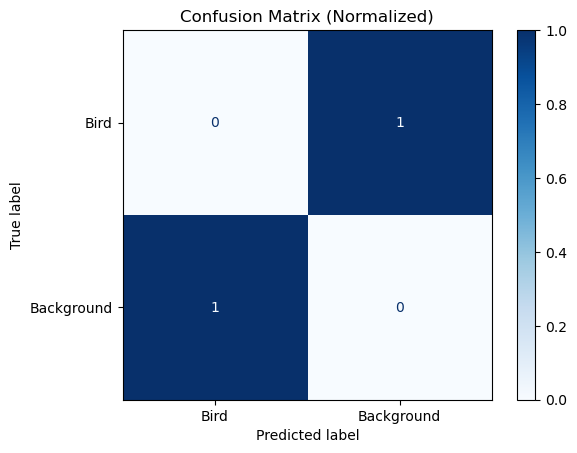

In [13]:
import pandas as pd

# Umbral para considerar una predicción como correcta
iou_threshold = 0.1
experiment = "predict_test_model12_conf015"

# Leer el archivo CSV con anotaciones
annotations_df = pd.read_csv('../BirdNET/Dataset/test_with_bg.csv')

annotations_df = group_consecutive_annotations_gt(annotations_df)
annotations_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame

# Listar archivos de predicciones
prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')

number_of_predictions = len(prediction_files)
print(f"Number of predictions: {number_of_predictions}")
print(f"Number of annotations: {len(annotations_df)}")

# Initialize an empty list to store prediction data
predictions_data = []

# Convert prediction files into a list of dictionaries with basename, start_time, end_time
for prediction in prediction_files:
    parts = prediction.split('_')
    basename = '_'.join(parts[:3])
    start_time = float(parts[-2])
    end_time = float(parts[-1].split('.W')[0])

    predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time})

    # predictions_interval = [start_time, end_time]
    
# Convert the list of dictionaries into a DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time'])

# Inicializar contadores
TP = 0
FP = 0
FN = 0
TN = 0

# Initialize lists for storing FP and FN predictions
fp_predictions = []
fn_predictions = []

# change annotations_df path to basename
annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

# Identificar anotaciones "No audio"
no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

# If there are basename of predictions that match basename of no_audio_annotations, they are false positive
if not no_audio_annotations.empty:
    for _, row in no_audio_annotations.iterrows():
        if row['basename'] in predictions_df['basename'].values:
            FP += len(predictions_df[predictions_df['basename'] == row['basename']])
            # Append FP predictions
            for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
        else:
            TN += len(predictions_df[predictions_df['basename'] == row['basename']])

# Eliminate empty audios from annotations_df
annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

# Loop through all predictions
for _, prediction in predictions_df.iterrows():
    matched = False
    for _, row in annotations_df.iterrows():
        annotation_interval = [row['start_time'], row['end_time']]
        prediction_interval = [prediction['start_time'], prediction['end_time']]
        iou = calculate_iou(prediction_interval, annotation_interval)
        if iou >= iou_threshold and prediction['basename'] == row['basename']:
            TP += 1
            matched = True
            break
    if not matched:
        FN += 1
        filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
        fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})
    
# Convert lists to DataFrames
fp_df = pd.DataFrame(fp_predictions)
fn_df = pd.DataFrame(fn_predictions)

# Calcular métricas de rendimiento
accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

cm = np.array([[TP, FP],
               [FN, TN]])

# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Asegurar que el valor mínimo sea 0
cm_normalized = np.nan_to_num(cm_normalized)

# Crear el display de la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Bird', 'Background'])

# Configurar la figura
plt.figure(figsize=(8, 6))

# Dibujar la matriz de confusión con cmap 'Blues'
disp_normalized.plot(cmap='Blues')

# Aumentar el tamaño de las celdas y ajustar los colores del texto

# Título de la matriz
plt.title('Confusion Matrix (Normalized)')

# Mostrar la figura
plt.show()

<Figure size 800x600 with 0 Axes>

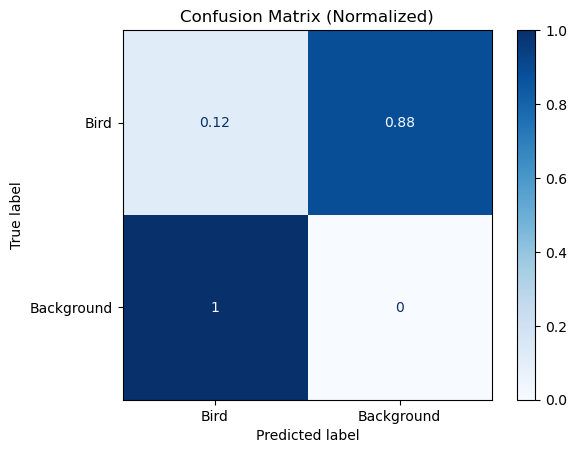

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Definir la matriz de confusión con los valores dados
'''cm = np.array([[54.9, 45.09],
               [100, 0]])'''

cm = np.array([[13, 100],
               [86.99, 0]])

# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Asegurar que el valor mínimo sea 0
cm_normalized = np.nan_to_num(cm_normalized)

# Crear el display de la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Bird', 'Background'])

# Configurar la figura
plt.figure(figsize=(8, 6))

# Dibujar la matriz de confusión con cmap 'Blues'
disp_normalized.plot(cmap='Blues')

# Aumentar el tamaño de las celdas y ajustar los colores del texto

# Título de la matriz
plt.title('Confusion Matrix (Normalized)')

# Mostrar la figura
plt.show()


In [ ]:
def analyze_predictions_BirdNET_Segments(analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0
    total_gt = len(gt_df)

    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None
    y_true = []
    y_pred = []
    species_list = sorted(gt_df['specie'].unique())

    for _, gt_annotation in gt_df.iterrows():
        prediction_path = f"../BirdNET/Predictions/{analysis_name}/{gt_annotation['path'].replace('.WAV', '.BirdNET.results.csv')}"
        current_file = gt_annotation['path']

        try:
            predictions_df = pd.read_csv(prediction_path)
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)

            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score

            grouped_predictions = [p for p in grouped_predictions if p["Confidence"] >= prediction_conf_score]

            if gt_annotation['specie'] != 'No audio':
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    score_threshold = False
                    for prediction in grouped_predictions:
                        if prediction['Confidence'] >= prediction_conf_score:
                            score_threshold = True

                    if score_threshold:
                        false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                    y_true.append(gt_annotation['specie'])
                    y_pred.append(get_predicted_species(grouped_predictions, prediction_conf_score))
                else:
                    false_negatives_classifier += 1
                    score_threshold = False
                    for prediction in grouped_predictions:
                        if prediction['Confidence'] >= prediction_conf_score:
                            score_threshold = True
                    
                    if score_threshold:
                        y_true.append(gt_annotation['specie'])
                        y_pred.append('Unknown')
            else:
                if current_file != last_file:
                    if current_predictions_score == 0:
                        true_negatives += 1
                    else:
                        false_positives += current_predictions_score

            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

    # Matriz de confusión general (Detector)
    cm_general = np.array([[true_positives_detector, false_negatives_detector],
                        [false_positives, true_negatives]])
    disp_general = ConfusionMatrixDisplay(confusion_matrix=cm_general, display_labels=['Positive', 'Negative'])
    plt.figure(figsize=(8, 6))
    disp_general.plot(cmap='Blues')
    plt.title('Confusion Matrix (General)')
    plt.show()

    # Matriz de confusión general normalizada
    cm_general = np.array([[true_positives_detector, false_negatives_detector],
                       [false_positives, true_negatives]])

    # Normalizar la matriz de confusión
    cm_general_normalized = cm_general.astype('float') / cm_general.sum(axis=1)[:, np.newaxis]

    # Asegurar que el valor mínimo sea 0
    cm_general_normalized = np.nan_to_num(cm_general_normalized)

    # Crear el display de la matriz de confusión normalizada
    disp_general_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_general_normalized, display_labels=['Positive', 'Negative'])

    # Configurar la figura
    plt.figure(figsize=(8, 6))

    # Dibujar la matriz de confusión con cmap 'Blues'
    disp_general_normalized.plot(cmap='Blues')
    plt.show()

    # Matriz de confusión por especie
    cm_species = confusion_matrix(y_true, y_pred, labels=species_list)
    plt.figure(figsize=(20, 20))
    disp_species = ConfusionMatrixDisplay(confusion_matrix=cm_species, display_labels=species_list)
    disp_species.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix by Species (Non-normalized)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Matriz de confusión por especie normalizada
    cm_species_normalized = confusion_matrix(y_true, y_pred, labels=species_list, normalize='true')
    plt.figure(figsize=(20, 20))
    disp_species_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_species_normalized, display_labels=species_list)
    disp_species_normalized.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix by Species (Normalized)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

def get_predicted_species(grouped_predictions, prediction_conf_score):
    high_conf_predictions = [p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score]
    if high_conf_predictions:
        return max(high_conf_predictions, key=lambda x: x['Confidence'])['Scientific name']
    else:
        return 'Unknown'